# Optimization - Predicted Angles vs. True Angles

[Michaël Defferrard](https://deff.ch), EPFL LTS2  
[Laurène Donati](https://people.epfl.ch/laurene.donati), EPFL BIG  
[Jelena Banjac](https://people.epfl.ch/jelena.banjac), EPFL MSc in Data Science

In [1]:
!pip install pyquaternion

You are using pip version 19.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
from time import time
import h5py
import os
from sklearn.neighbors import NearestNeighbors
import seaborn as sns; sns.set(style="white", color_codes=True)
import ipyvolume as ipv

import sys
sys.path.append("..") 
from cryoem.plots import plot_projection, plot_projections
from cryoem.projections import RotationMatrix
#from cryoem.quaternions import euler2quaternion, quaternion2euler, d_Q
#from pyquaternion import Quaternion

import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow_graphics.util import asserts
from tensorflow_graphics.math import vector
from tensorflow_graphics.util import safe_ops
from tensorflow_graphics.util import shape
from tensorflow_graphics.geometry.transformation import quaternion, euler

---

## Data

In [2]:
n_samples = 5000

In [3]:
angle_ranges = "2.0,0.4,2.0"
angle_shift = "0.0,0.0,0.0"
projections_filename = f"../data/bgal/bgal_ProjectionsAngles_ProjNber5000_AngCoverage{angle_ranges}_AngShift{angle_shift}.h5"
# load structures
data = h5py.File(projections_filename, 'r')

print(f"{data['Projections'].shape[0]} projections of images with dimension {data['Projections'].shape[1:]} pixels")
print(f"{data['Angles'].shape[0]} sets of {data['Angles'].shape[1]} ground truth angles of corresponding projection images")

5000 projections of images with dimension (136, 136) pixels
5000 sets of 3 ground truth angles of corresponding projection images


In [4]:
# plot
all_vectors = RotationMatrix(data["Angles"])
ipv.figure(width=500, height=500)
ipv.pylab.xlim(-1, 1)
ipv.pylab.ylim(-1, 1)
ipv.pylab.zlim(-1, 1)
ipv.scatter(all_vectors[:,0], all_vectors[:,2], all_vectors[:,1], marker="sphere", color="blue", size=1)
ipv.pylab.save(f"data/angle_variety/{angle_ranges}.html")
ipv.show()

##### Angles

###### Predicted Angles 

In [5]:
low_ang = np.pi/2
high_ang = 2*np.pi - np.pi/2

euler = np.random.uniform(low=[low_ang, low_ang, low_ang], 
                          high=[high_ang, high_ang, high_ang],
                          size=(n_samples, 3))

# angles_predicted = [tf.Variable(e, constraint=lambda x: tf.clip_by_value(x, low_ang, high_ang)) for e in euler]
angles_predicted = tf.Variable(euler)  #[tf.Variable(e) for i, e in enumerate(euler)]
print(f"Angles predicted: (min, max) = ({tf.reduce_min(angles_predicted):.4f}, {tf.reduce_max(angles_predicted):.4f})")

#angles_predicted = np.array(angles_predicted)
angles_predicted.shape

Angles predicted: (min, max) = (1.5708, 4.7122)


TensorShape([5000, 3])

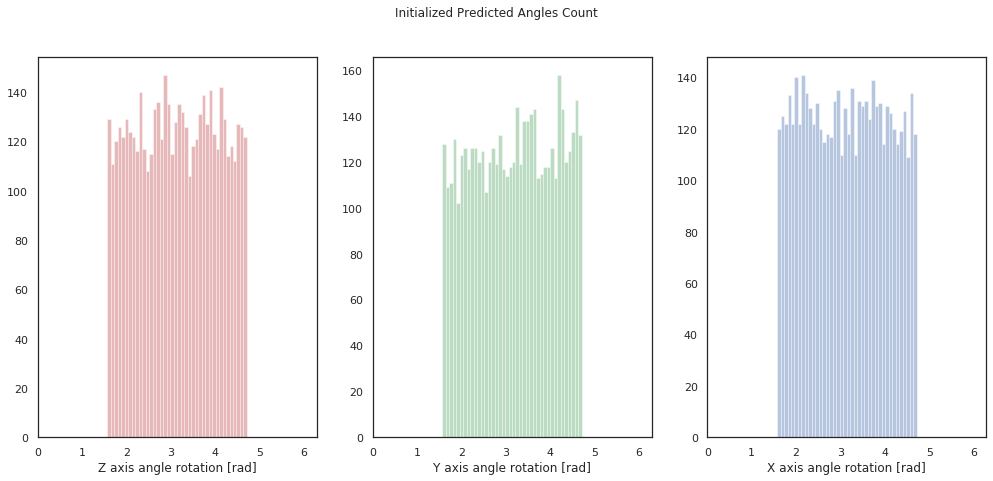

In [6]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x]) for x in angles_predicted.numpy()])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Initialized Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=40, ax=axs[2], axlabel="X axis angle rotation [rad]", color="b");

###### True Angles 

In [7]:
angles_true = np.reshape(data["Angles"], (data["Angles"].shape[0], -1))
print(f"Angles true: (min, max) = ({np.min(angles_true):.4f}, {np.max(angles_true):.4f})")

angles_true = np.array(angles_true)
angles_true.shape

Angles true: (min, max) = (0.0000, 6.2812)


(5000, 3)

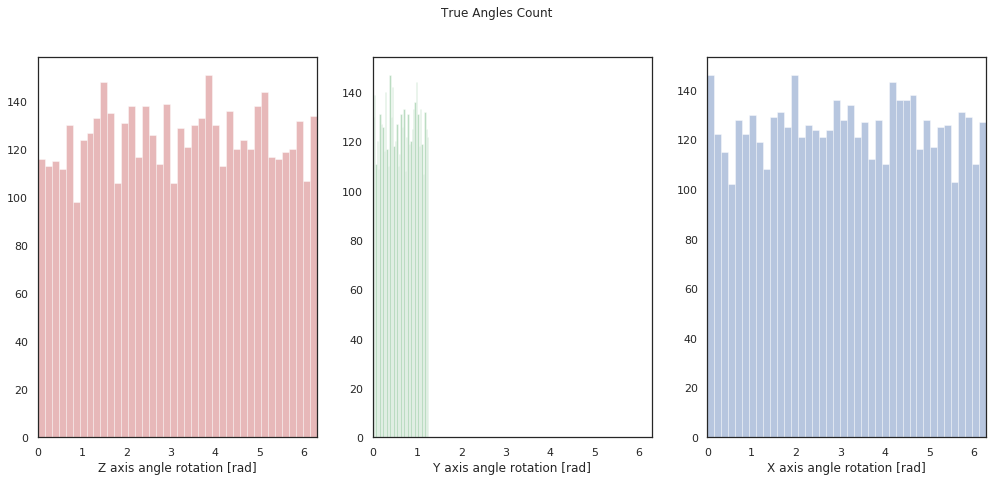

In [8]:
fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("True Angles Count")

sns.distplot(angles_true[:,0], kde=False, bins=40, ax=axs[0], axlabel="Z axis angle rotation [rad]", color="r")
sns.distplot(angles_true[:,1], kde=False, bins=40, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(angles_true[:,2], kde=False, bins=40, ax=axs[2], axlabel="X axis angle rotation [rad]", color="b");

##### Projections

In [9]:
# projections = np.reshape(data["Projections"], (data["Projections"].shape[0], -1))
# projections.shape

In [10]:
# n_pixels = projections.shape[1]

---

## Distances

##### Angle Distances

In [41]:
def euler2quaternion(a):
    """
    Quaternion implements 3 rotations along x, y, z axis. 
    We compose them to get the final (single) rotation.
    """
    tf.compat.v1.enable_eager_execution()
    
    print(a[0])
    print(type(a[0]))
    if isinstance(a[0], np.ndarray):
        a = tf.convert_to_tensor(a)
    elif isinstance(a[0], float):
        a = np.array(np.array([a]))
        a = tf.convert_to_tensor(a)
    
    # axes
    angles_num = len(a)
    x = np.array([1., 0., 0.]*angles_num).reshape((-1,3))
    y = np.array([0., 1., 0.]*angles_num).reshape((-1,3))
    z = np.array([0., 0., 1.]*angles_num).reshape((-1,3))

    a = tf.reshape(a, [-1,angles_num])
    gamma = tf.reshape(a[0], [-1, 1])
    beta = tf.reshape(a[1], [-1, 1])
    alpha = tf.reshape(a[2], [-1, 1])

    qz1 = quaternion.from_axis_angle(axis=z, angle=gamma)
    qy2 = quaternion.from_axis_angle(axis=y, angle=beta)
    qz3 = quaternion.from_axis_angle(axis=z, angle=alpha)

    q = qz1*qy2*qz3
    q = quaternion.normalize(q)

    return q

def quaternion2euler(q):
    e0 = q[0]
    e1 = q[1] 
    e2 = q[2]
    e3 = q[3]

    alpha = np.arctan2(e1*e3+e0*e2, -(e2*e3-e0*e1))
    beta = np.arccos(1-2*(e1**2 + e2**2))
    if beta < 0 or beta > np.pi:
        raise ValueError 
    gamma = np.arctan2(e1*e3-e0*e2, e2*e3+e0*e1)

    angles = [gamma, beta, alpha]

    return angles

def d_q(q1, q2):
     tf.compat.v1.enable_eager_execution()
    
     with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",
                                 [q1, q2])):
        q1 = tf.convert_to_tensor(value=q1)
        q2 = tf.convert_to_tensor(value=q2)
      
        shape.check_static(
            tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
        shape.check_static(
            tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

        q1 = quaternion.normalize(q1)
        q2 = quaternion.normalize(q2)
        
        dot_product = vector.dot(q1, q2, keepdims=False)
        
        # Ensure dot product is in range [-1. 1].
        const = 1.8 #4.0 #.63
        eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
        dot_product = safe_ops.safe_shrink(
            dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

        return 2.0 * tf.acos(tf.abs(dot_product)) 

In [24]:
# def d_q(q1, q2):
#      with (tf.compat.v1.name_scope(None, "quaternion_relative_angle",
#                                  [q1, q2])):
#         q1 = tf.convert_to_tensor(value=q1)
#         q2 = tf.convert_to_tensor(value=q2)
      
#         shape.check_static(
#             tensor=q1, tensor_name="quaternion1", has_dim_equals=(-1, 4))
#         shape.check_static(
#             tensor=q2, tensor_name="quaternion2", has_dim_equals=(-1, 4))

#         q1 = quaternion.normalize(q1)
#         q2 = quaternion.normalize(q2)
        
#         dot_product = vector.dot(q1, q2, keepdims=False)
        
#         # Ensure dot product is in range [-1. 1].
#         const = 1.8 #4.0 #.63
#         eps_dot_prod = const * asserts.select_eps_for_addition(dot_product.dtype)
#         dot_product = safe_ops.safe_shrink(
#             dot_product, -1, 1, open_bounds=False, eps=eps_dot_prod)

#         return 2.0 * tf.acos(tf.abs(dot_product))
    

In [42]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_true[0:4]), euler2quaternion(angles_true[0:4]))) < 1e-7

[4.09664817 0.52565596 4.93918506]
<class 'numpy.ndarray'>
[4.09664817 0.52565596 4.93918506]
<class 'numpy.ndarray'>


In [43]:
assert tf.reduce_mean(d_q(euler2quaternion(angles_predicted[0:4]), euler2quaternion(angles_predicted[0:4]))) < 1e-7

tf.Tensor([2.48561421 2.61521861 4.55179461], shape=(3,), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([2.48561421 2.61521861 4.55179461], shape=(3,), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


In [44]:
assert (d_q(euler2quaternion([np.pi/2]*3), euler2quaternion([2*np.pi-np.pi/2]*3))-np.pi) < 1e-7

1.5707963267948966
<class 'float'>
4.71238898038469
<class 'float'>


##### Projection Distance

In [9]:
# def d_p(p1, p2):
#     # (learned) distance between two images.
#     # for now, Euclid dist
#     p1 = tf.convert_to_tensor(value=p1, dtype=np.float32)
#     p2 = tf.convert_to_tensor(value=p2, dtype=np.float32)

#     if len(p1.shape) > 1:
#         dist = tf.norm(p1-p2, ord='euclidean', axis=1, keepdims=True)
#     else:
#         dist = tf.norm(p1-p2, ord='euclidean')

#     return dist

# assert tf.reduce_mean(d_p(projections[0:3], projections[0:3])) < 1e-7

---

## Loss and gradient

Our goal is to then optimize
$$ \operatorname*{arg\,min}_{\{\hat{Q}_i\}_{i=1}^n} \sum_{i,j} \left| d_p(p_i, p_j) - d_Q(\hat{Q}_i, \hat{Q}_j) \right|^2, $$
where $p_i$ is a projected image and $d_p$ is a (learned) distance between two images.

In [46]:
def loss(a1_predicted, a2_predicted, distance_target):
#     q1_predicted = quaternion.from_euler(a1_predicted)
#     q2_predicted = quaternion.from_euler(a2_predicted)
    
#     q1 = quaternion.normalize(q1_predicted)
#     q2 = quaternion.normalize(q2_predicted)

    q1_predicted = euler2quaternion(a1_predicted)
    q2_predicted = euler2quaternion(a2_predicted)

    distance = d_q(q1_predicted, q2_predicted)
    
#     distance = d_q(q1, q2)
    
#     distance        = normalize_quaternion_distance(distance)
#     distance_target = normalize_quaternion_distance(distance_target)
    
    # The mean doesn't depend on the batch size.
    return tf.reduce_mean((distance - distance_target)**2)

In [47]:
def gradient(a1_predicted, a2_predicted, distance_target):
    with tf.GradientTape() as tape:
        tape.watch(a1_predicted + a2_predicted)
        loss_value = loss(a1_predicted, a2_predicted, distance_target)
    
    gradient = tape.gradient(loss_value, a1_predicted + a2_predicted)
        
    return loss_value, gradient

---

## Optimization loop (angles-true & angles-predict)

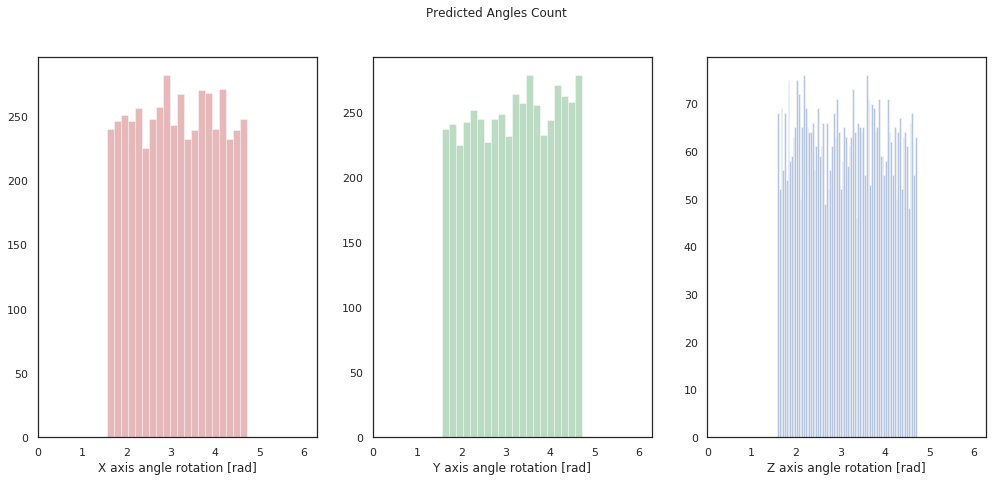

In [31]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x]) for x in angles_predicted.numpy()])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="X axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z axis angle rotation [rad]", color="b");

In [48]:
steps=10000
batch_size=256

#optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1)

losses = np.empty(steps)
time_start = time()

for step in range(1, steps+1):

    # Sample some pairs.
    idx1 = list(np.random.randint(0, n_samples, batch_size))
    idx2 = list(np.random.randint(0, n_samples, batch_size))
    a1 = [angles_predicted[i] for i in idx1]
    a2 = [angles_predicted[i] for i in idx2]

    # Compute distances between projections
    a1_true = [angles_true[i] for i in idx1]
    a2_true = [angles_true[i] for i in idx2]
    q1_true = euler2quaternion(a1_true)
    q2_true = euler2quaternion(a2_true)
    
#     q1_true = quaternion.from_euler(a1_true)
#     q2_true = quaternion.from_euler(a2_true)
#     q1_true = quaternion.normalize(q1_true)
#     q2_true = quaternion.normalize(q2_true)

#     distance_target = d_q(q1_true, q2_true)
    distance_target = d_q(q1_true,q2_true)
    

    # Optimize by gradient descent.
    losses[step-1], gradients = gradient(a1, a2, distance_target)
    optimizer.apply_gradients(zip(gradients, a1 + a2))

    # Periodically report progress.
    if ((step % (steps//10)) == 0) or (step == steps):
        time_elapsed = time() - time_start
        print(f'step {step}/{steps} ({time_elapsed:.0f}s): loss = {losses[step-1]:.2e}')

# Plot convergence.
plt.figure(figsize=(15,10))
plt.plot(np.linspace(0, time()-time_start, steps), losses)
plt.xlabel('time [s]')
plt.ylabel('loss');

[0.68079099 0.22654627 2.57271558]
<class 'numpy.ndarray'>
[2.26587734 0.68774669 0.3864298 ]
<class 'numpy.ndarray'>
tf.Tensor([1.65746448 1.96573898 2.2304852 ], shape=(3,), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>
tf.Tensor([2.4440917  3.81651368 4.66406142], shape=(3,), dtype=float64)
<class 'tensorflow.python.framework.ops.EagerTensor'>


AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute '_in_graph_mode'

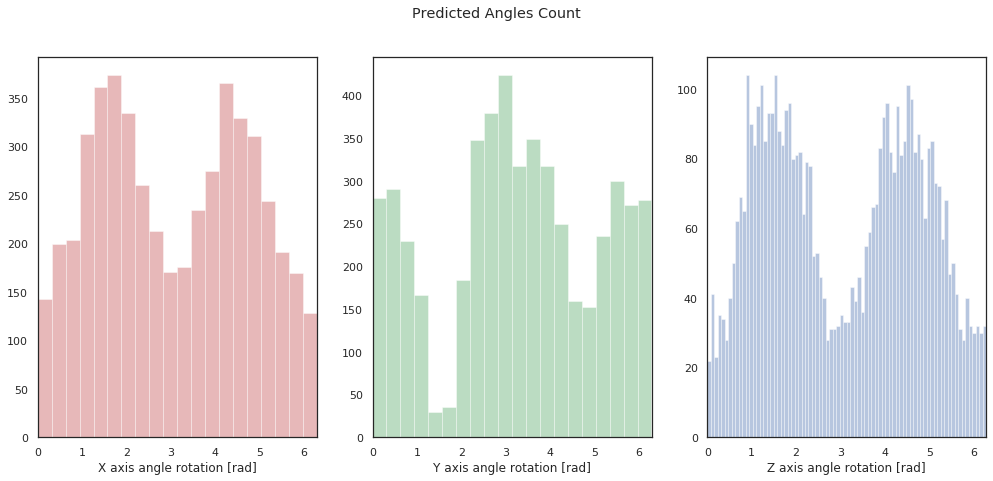

In [17]:
angles_predicted_plot = np.array([ np.array([(y%(2*np.pi)) for y in x.numpy()]) for x in angles_predicted])

fig, axs = plt.subplots(1, 3, figsize=(17,7))
axs[0].set_xlim(0,2*np.pi)
axs[1].set_xlim(0,2*np.pi)
axs[2].set_xlim(0,2*np.pi)
plt.suptitle("Predicted Angles Count")

sns.distplot(angles_predicted_plot[:,0], kde=False, bins=20, ax=axs[0], axlabel="X axis angle rotation [rad]", color="r")
sns.distplot(angles_predicted_plot[:,1], kde=False, bins=20, ax=axs[1], axlabel="Y axis angle rotation [rad]", color="g")
sns.distplot(angles_predicted_plot[:,2], kde=False, bins=80, ax=axs[2], axlabel="Z axis angle rotation [rad]", color="b");